-- <font color='gray'>**Evelyn Liu, Adam Hughes**</font> 

-- <font color='gray'>**3/24/14**</font> 

-- <font color='gray'>**The George Washington University**</font> 

# Ilastik's classification vs. User-defined Partition

### Objective

This notebook implements the [usermodel script](http://127.0.0.1:8888/notebooks/usermodel.ipynb), demonstrating pyparty's implementation of user-defined object classification.

### Environment Setup

Configure notebook style (see NBCONFIG.ipynb), add imports and paths.  The **%run** magic used below <font color='red'>**requires IPython 2.0 or higher.**</font>

In [1]:
%run NBCONFIG.ipynb
%pylab inline

from pyparty.plots import showim, multishow, splot

Populating the interactive namespace from numpy and matplotlib


#### Import labeled and unlabeled test data.  Optionally crop to run faster

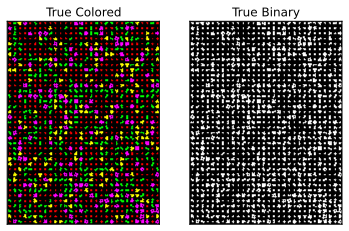

In [2]:
from pyparty.utils import crop
from _shared import load_test_image
from skimage.color import rgb2gray

#CROP = (0,0,1000,1024)  
CROP = None

EXACT_LABELED = load_test_image('Noise_seg_12_color.png', crop=CROP,
                          relpath='Test_Data/Ilastik_Analysis_Final/seg_12_labels')

EXACT_BINARY = rgb2gray(EXACT_LABELED) > 0 #gray convert because 3-channel bool ambiguous

multishow([EXACT_LABELED, EXACT_BINARY], 
          names=['True Colored', 'True Binary'], nolabel=True);

In [3]:
EXACT_LABELED = EXACT_LABELED[:,:,0:3]

MultiCanvas (0x90e5b90) 1170: 
  Single    -  Canvas (0x90e54d0) : 3072 X 2304 : 585 particles
  Dimer     -  Canvas (0x90e5d10) : 3072 X 2304 : 293 particles
  Trimer    -  Canvas (0x90e5e30) : 3072 X 2304 : 146 particles
  Tetramer  -  Canvas (0x510f530) : 3072 X 2304 : 146 particles


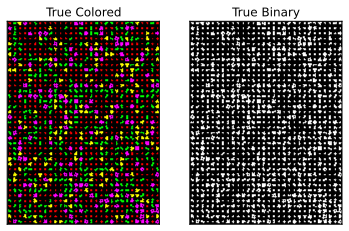

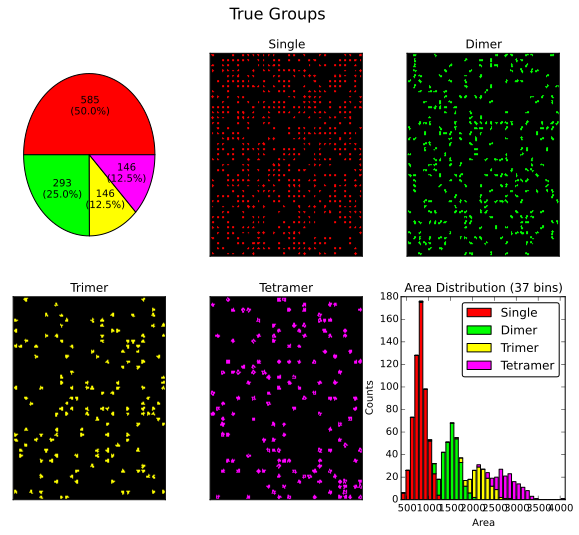

In [4]:
from pyparty import MultiCanvas 

NAMES = ['Single', 'Dimer', 'Trimer', 'Tetramer']
COLORS = [(1,0,0), (0,1,0), (1,1,0), 'magenta'] #bright red, green, yellow

def mc_sixplot(mc, title=None):
    """ Collage of plots given a MC, mc"""
    fig, AXES = splot(2,3, figsize=(10,8), fig=True)
    mc.pie(AXES[0], autopct='both', annotate=False)
    for idx in range(len(mc)):
        mc[idx].background='black'
    mc.show(names=True, nolabel=True, axes=AXES[1:5])
    mc.hist(AXES[5], bins=37, xlim='auto')
    if title:
        fig.suptitle(title, fontsize=16)
        
mc_exact = MultiCanvas.from_labeled(EXACT_LABELED, ignore='black', mapper=zip(NAMES, COLORS))
 
multishow([EXACT_LABELED, EXACT_BINARY], names=['True Colored', 'True Binary'], nolabel=True)

print mc_exact
mc_sixplot(mc_exact, title='True Groups');

First we will build a filter based on basic shape parameters like *area* and *circularity*.  Afterwards, we will see how that performs vs. some Ilastik segmentation results and compare both to the true values from the labeled image.

#### Step 1: Read unlabled image into a canvas to begin looking at particle attributes.

Canvas (0x75d7290):
   background  -->  (3072 X 2304) : ndarray
   particles   -->  1170 particles : 1 types
   xygrid[1020] -->  (68p X 15p) : (33.9 X 204.7) [pix/tile]


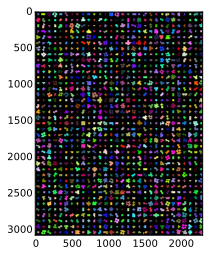

In [5]:
c = Canvas(background=EXACT_BINARY)
clab = c.from_labels(exclude='black', pbinary=False, pmin=10, neighbors=4)
print clab
clab.show();

#### Step 2: Histogram of various descriptors

Let's take a look at the distribution of various shape (circularity, minor_axis_length) and size (equivalent_diameter, perimeter, area) descriptors.

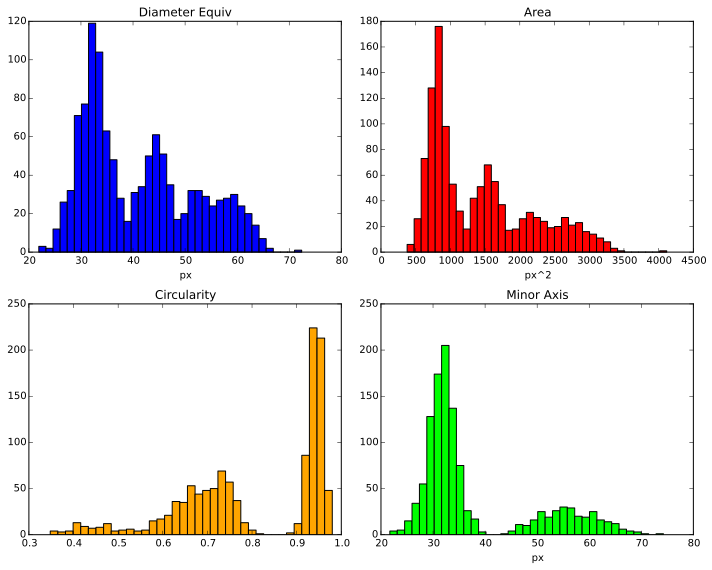

In [6]:
from pyparty.plots import splot

# Store various attribute arrays
areas = clab.area
diams = clab.equivalent_diameter
circ = clab.circularity
minor, major = clab.minor_axis_length, clab.major_axis_length
perim = clab.perimeter

# Plots
BINS = 37
ax1, ax2, ax3, ax4 = splot(2,2, figsize=(10,8))

ax1.hist(diams, BINS, color='blue')
ax1.set_title('Diameter Equiv')
ax1.set_xlabel('px')

ax2.hist(areas, BINS, color='r')
ax2.set_title('Area')
ax2.set_xlabel('px^2')

ax3.hist(circ, BINS, color='orange')
ax3.set_title('Circularity')

ax4.hist(minor, BINS, color=(0,1,0))
ax4.set_title('Minor Axis')
ax4.set_xlabel('px')

plt.tight_layout();

We see that shape descriptors have a very clear separation of single particles from others.  This is more pronounced in *circularity* than *minor axis*.  Let's explore the correlation between various combos of these parameters.  This will illustrate how various combinations of shape and size parameters give nature choices for selection of filter attributes.  We emply the canvas' builtint scatter() wrapper.

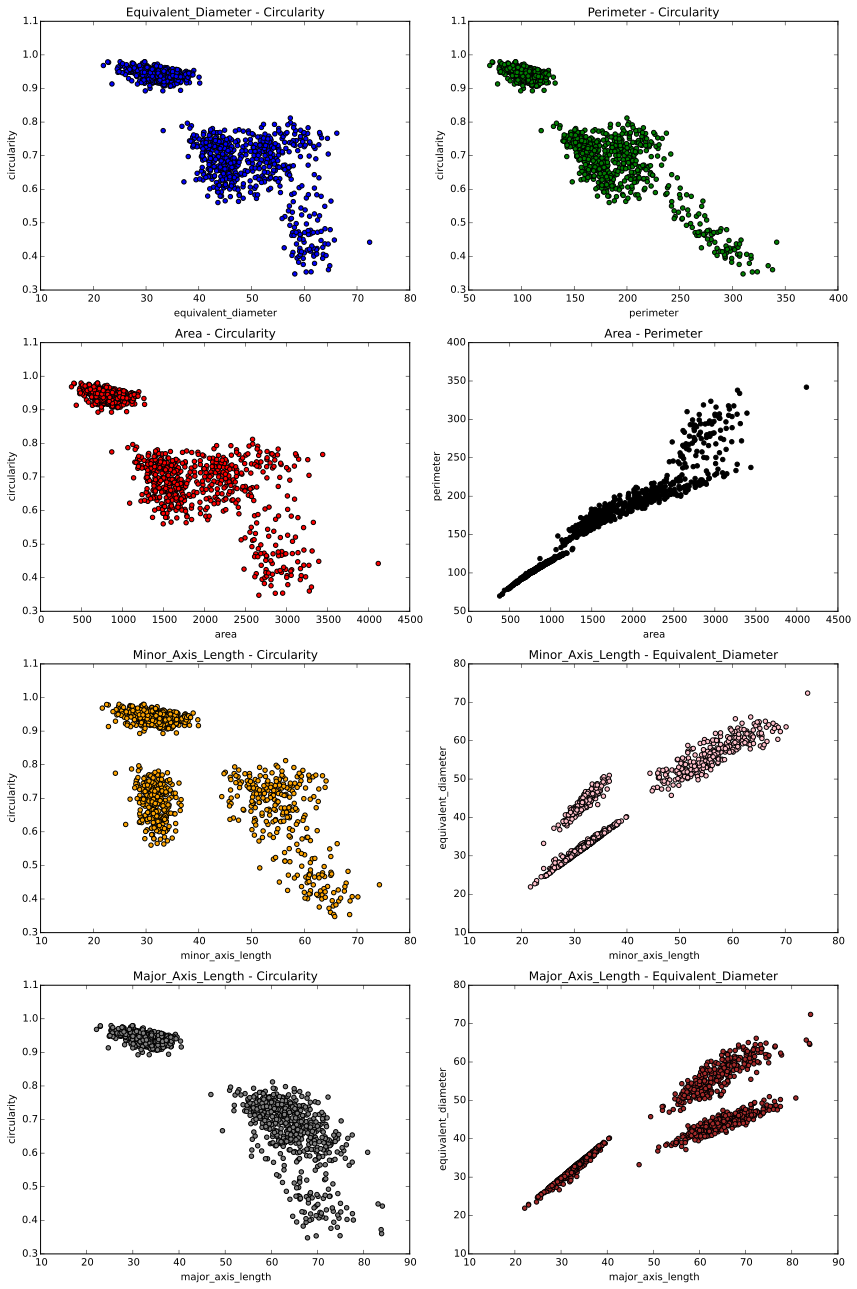

In [7]:
SCATTKWDS = {'alpha':0.75, 'lw':1, 'edgecolor':'0.3'} #lw=0 for borderless markers
AXES = splot(4,2, figsize=(12,18))
PAIRS = (('equivalent_diameter', 'circularity', 'b'), 
            ('perimeter', 'circularity', 'g'),
            ('area', 'circularity', 'r'),
            ('area', 'perimeter', 'black'),
            ('minor_axis_length', 'circularity', 'orange'),
            ('minor_axis_length', 'equivalent_diameter', 'pink'),
            ('major_axis_length', 'circularity', 'gray'),
            ('major_axis_length', 'equivalent_diameter', 'brown') )

for idx, (a1, a2, color) in enumerate(PAIRS):
    clab.scatter(AXES[idx], attr1=a1, attr2=a2, c=color, annotate=True)
plt.tight_layout()

**Circularity and semi-minor axis length give really nice separation.**  Perhaps this is expected, as semi-minor-axis nicely rolls shape and size criteria into a single descriptor.  Perimeter and area on the other hand contain lots of redundant information so of course they're bad for separting paritcle types.  Let's make nicer versions of these plots:

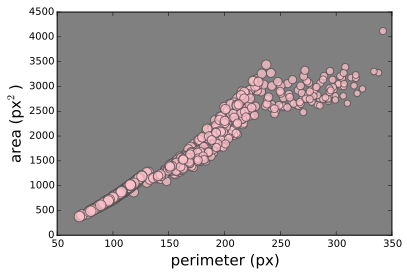

In [8]:
ax = subplot(111, axisbg='gray')
SCATTKWDS['s']=circ*115
ax.scatter(perim, areas, color='pink', **SCATTKWDS)

ax.set_xlabel('perimeter (px)', size=15)
ax.set_ylabel('area (px$^2$)', size=15);
plt.xlim(50,350)
plt.savefig('/media/backup/Dropbox/Writeups_Notes_and_Applications/PLANNED_PAPERS/III-VII_SEMSUMMARY/images/area_perim.png')

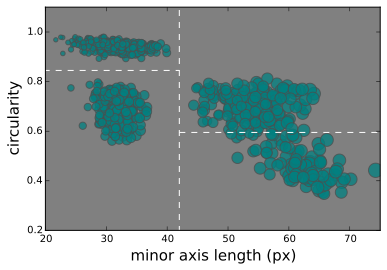

In [9]:
LINEKWDS = {'linestyle':'--', 'linewidth':1, 'color':'white'}
SCATTKWDS['s'] = areas/20

ax = subplot(111, axisbg='gray')
p1 = ax.scatter(minor, circ, color='teal', **SCATTKWDS)

#PARTITION
HTOP = 0.85
HBOTTOM = 0.6
MID = 42
PAD = 0.005 # Wiggle the lines a bit, used for final plot

def drawpartition():
    """ Draw partition from model in white """
    plt.hlines(y=HTOP - PAD, xmin=0, xmax=MID, **LINEKWDS) # Single/dimer boundary
    plt.vlines(x=MID, ymin=0, ymax=1.6, **LINEKWDS) # Vertical boundary
    plt.hlines(y=HBOTTOM - PAD, xmin=MID, xmax=80, **LINEKWDS)

drawpartition()
ax.set_xlabel('minor axis length (px)', size=15)
ax.set_ylabel('circularity', size=15)

XMIN=20
XMAX=75

ax.set_xlim(XMIN, XMAX)
ax.set_ylim(.2,1.1);
plt.savefig('/media/backup/Dropbox/Writeups_Notes_and_Applications/PLANNED_PAPERS/III-VII_SEMSUMMARY/images/junk.png'
           ,dpi=200)

The white line represent partitions that we'd like to specify for filters.  These cuts were chosen to ensure no overlap (ie they divide the space eveny as shown below).  **In pyparty, we can partition the data according to such simple descriptors through the following model**:

#### Step 3: Create a multicanvas from a model based on the partition above.

MultiCanvas (0x502937d0) 1170: 
  Single    -  Canvas (0x54994f50) : 3072 X 2304 : 585 particles
  Dimer     -  Canvas (0x5409db90) : 3072 X 2304 : 293 particles
  Trimer    -  Canvas (0x53f6a110) : 3072 X 2304 : 199 particles
  Tetramer  -  Canvas (0x4eb19f50) : 3072 X 2304 : 93 particles 


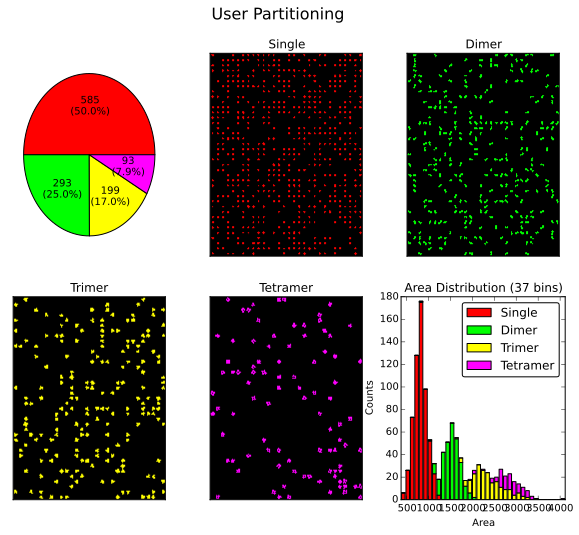

In [ ]:
from pyparty.scripts import Descriptor, Model

class Single(Descriptor):
    classifier = '(minor_axis_length < %s) & (circularity > %s)' % (MID, HTOP)
    color = COLORS[0]

class Dimer(Descriptor):
    classifier = '(minor_axis_length < %s) & (circularity < %s)' % (MID, HTOP)
    color =  COLORS[1]        
    #alias = 'little circles'
        
class Trimer(Descriptor):
    classifier = '(minor_axis_length > %s) & (circularity > %s)' % (MID, HBOTTOM)
    color =  COLORS[2]

class Tetramer(Descriptor):
    classifier = '(minor_axis_length > %s) & (circularity < %s)' % (MID, HBOTTOM)
    color =  COLORS[3]
    
model = Model( *[Single(), Dimer(), Trimer(), Tetramer()] )
mc_model = model.to_multicanvas(clab)

print mc_model
mc_sixplot(mc_model, title='User Partitioning')

#### Step 4: Turn the model into a multicanvas and see the estimations for the groups.

### Import labels from semi-supervised learning through Ilastik[1]

We will compare our partitions (above) and those from object classification in Ilastik, which uses semi-supervised learning to identify groups.  Both of these will be compared to the true labeled image.

#### Step 5:  Import the Ilasitk results (ie pre-labeled image) and decompose into a MultiCanvas

In [ ]:
ILASTIK_LABELED = load_test_image('Noise_class_10labels_modified.png', crop=CROP,
                          relpath='Test_Data/Ilastik_Analysis_Final/class_10_labels')

mc_ilastik = MultiCanvas.from_labeled(ILASTIK_LABELED, ignore='black',  
                                      mapper=zip(NAMES, COLORS) )

print mc_ilastik
mc_sixplot(mc_ilastik, title='Ilastik Model on non-rastered image');

##### Step 6: Output ilastik predicted groups vs. true groups into a scatter plot with partitioned background.

The following two cells are inspired by this link *Plot multi-class SGD on the iris dataset*:

http://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_iris.html

In [ ]:
SCATTKWDS.pop('s', None)

x_min = XMIN 
hx = 0.1
x_max = XMAX+hx
y_min = 0.2
hy = 0.01
y_max = 1.1+hy
### xx, yy are meshgrid to help coloring four regions, which will be done in the definiton of Z
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),  np.arange(y_min, y_max, hy))

### Z: Define the color or each group region. Z value represents for the color.
### Values of Z are 0,1,2 and 4 respectively for singles, dimers, trimers and tetramers.
### Not sure about the relation between number and color. 
### I chose 0,1,2,4 because they gave us light blue, green, red and yellow.

Z = [[0 for x in xrange(len(xx[0]))] for x in xrange(len(xx))] 
for i in range(0,len(xx)):
    for j in range(0,len(xx[0])):
        if (xx[i][j]<=MID) & (yy[i][j]>=HTOP): #singles
            Z[i][j]=2
        elif (xx[i][j]<MID) & (yy[i][j]<HTOP): #dimers
            Z[i][j]=1
        elif (xx[i][j]>=MID) & (yy[i][j]>=HBOTTOM): #trimers
            Z[i][j]=4
        elif (xx[i][j]>MID) & (yy[i][j]<HBOTTOM): #tetramers
            Z[i][j]=0
            

def partition_plot(mc, legend=False):
    """ Draw partition boxes over plot """
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    drawpartition()

    p1 = plt.scatter(mc['Single'].minor_axis_length, mc['Single'].circularity, 
            c=COLORS[0], s=mc['Single'].area/20, **SCATTKWDS)

    p2 = plt.scatter(mc['Dimer'].minor_axis_length, mc['Dimer'].circularity, 
            c=COLORS[1], s=mc['Dimer'].area/20, **SCATTKWDS)

    p3 = plt.scatter(mc['Tetramer'].minor_axis_length, mc['Tetramer'].circularity,
            c=COLORS[3], s= mc['Tetramer'].area/20, **SCATTKWDS)

    # TRIMERS APPEAR ON TOP
    p4 = plt.scatter(mc['Trimer'].minor_axis_length, mc['Trimer'].circularity, 
            c=COLORS[2], s=mc['Trimer'].area/20, **SCATTKWDS)

    plt.xlim(XMIN, XMAX)
    plt.ylim(0.2,1.1)
    if legend:
        # ALMOST CIRCLE LEGEND MARKERS
#        proxy = [plt.Line2D([0],[0], marker=0, color = color) for color in COLORS]
#        plt.legend(proxy, NAMES, ncol=2, fontsize=8, loc='upper right') 
 
        # RECTANGLE LEGEND MARKER
        proxy = [plt.Rectangle((0,0),1,1, color = color) for color in COLORS]
        plt.legend(proxy, NAMES, ncol=2, fontsize=8, loc='upper right') 
        
    
subplot(121)    
partition_plot(mc_ilastik)
plt.title('Ilastik Groups')
plt.xlabel('minor axis length (px)')
plt.ylabel('circularity')

subplot(122)
partition_plot(mc_exact, legend=True)
plt.title('True Groups');
plt.tick_params(labelbottom='off', labelleft='off')
plt.tight_layout()

### References

- [1] : [Ilastik](http://ilastik.org/index.php?cat=How%20to%20cite) C. Sommer, C. Straehle, U. Köthe, and F.A. Hamprecht
8th IEEE International Symposium on Biomedical Imaging (ISBI 2011), in press

### Related

- [scikit-image descriptors](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=region%20props#skimage.measure.regionprops)
- [matplotlib multiplot layouts](http://www.loria.fr/~rougier/teaching/matplotlib/)
- [pyparty user Models/Filters tutorial](http://nbviewer.ipython.org/github/hugadams/imgproc_supplemental/blob/master/Notebooks/usermodel.ipynb)

### Redistribution

This notebook is free for redistribution.  If referencing, please cite as:

- Hughes, A. (2012). [A Computational Framework for Plasmonic Nanobiosensing](https://www.researchgate.net/publication/236672995_A_Computational_Framework_for_Plasmonic_Nanobiosensing).  Python in Science Conference [SCIPY]. 